In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.integrate import cumtrapz

## Constantes

In [5]:
rho_Be = 1.85 # g/cm3
rho_PMMA = 1.18
rho_Adipose = 0.916
rho_Glandular = 1.041
rho_Poly = 1.22
rho_Air = 0.001293

d_SD = 65.6
d_mama = 4 #cm
d_esc = 3.161 # cm
d_Be = 0.1 
d_Poly = 0.3
d_Aire = d_SD - d_mama - d_Be - d_Poly

# Cargamos el espectro

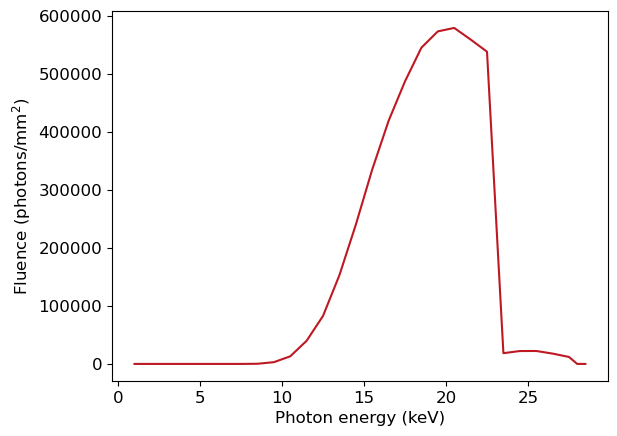

In [17]:
data = np.genfromtxt("spectrum.txt")
energies_spect = data[:,0]
spectrum = data[:,1]
plt.plot(energies_spect, spectrum, color="#BE1823")
plt.xlabel("Photon energy (keV)", fontsize=12)
plt.ylabel(r"Fluence (photons/mm$^2$)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Spectrum.svg")

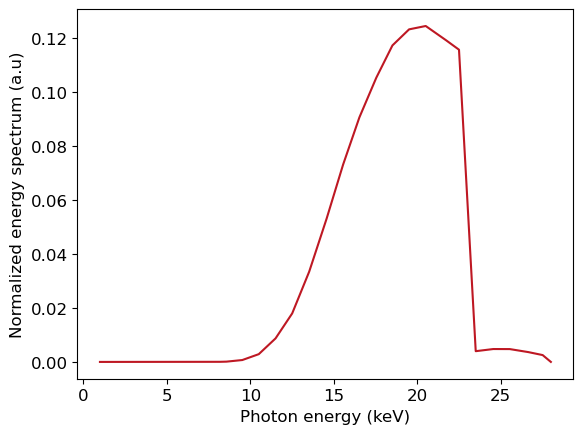

In [20]:
f_spectrum = interpolate.interp1d(energies_spect, spectrum, kind="linear")
energies = np.linspace(1,28,10000)
spectrum_prov = f_spectrum(energies)
new_spectrum = spectrum_prov/np.trapz(spectrum_prov, x=energies)

plt.plot(energies, new_spectrum, color="#BE1823")
plt.xlabel("Photon energy (keV)", fontsize=12)
plt.ylabel(r"Normalized energy spectrum (a.u)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("Spectrum.svg")

## Interpolamos los valores de energía de los coef. de atenuación

In [8]:
data_Be = np.genfromtxt("Beryllium.txt")
data_PMMA = np.genfromtxt("PMMA.txt")
data_Adipose = np.genfromtxt("Adipose.txt")
data_Glandular = np.genfromtxt("Glandular.txt")
data_Poly = np.genfromtxt("polycarbonate.txt")
data_Air = np.genfromtxt("Air.txt")

E_Be, mu_Be = data_Be[:,0]*1000, data_Be[:,1]*rho_Be
E_PMMA, mu_PMMA = data_PMMA[:,0]*1000, data_PMMA[:,1]*rho_PMMA
E_Adipose, mu_Adipose = data_Adipose[:,0]*1000, data_Adipose[:,1]*rho_Adipose
E_Glandular, mu_Glandular = data_Glandular[:,0]*1000, data_Glandular[:,1]*rho_Glandular
E_Poly, mu_Poly = data_Poly[:,0]*1000, data_Poly[:,1]*rho_Poly
E_Air, mu_Air = data_Air[:,0]*1000, data_Air[:,1]*rho_Air

f_Be = interpolate.interp1d(E_Be, mu_Be, kind="linear")
nmu_Be = f_Be(energies)

f_PMMA = interpolate.interp1d(E_PMMA, mu_PMMA, kind="linear")
nmu_PMMA = f_PMMA(energies)

f_Adipose = interpolate.interp1d(E_Adipose, mu_Adipose, kind="linear")
nmu_Adipose = f_Adipose(energies)

f_Glandular = interpolate.interp1d(E_Glandular, mu_Glandular, kind="linear")
nmu_Glandular = f_Glandular(energies)

f_Poly = interpolate.interp1d(E_Poly, mu_Poly, kind="linear")
nmu_Poly = f_Poly(energies)

f_Air = interpolate.interp1d(E_Air, mu_Air, kind="linear")
nmu_Air = f_Air(energies)


## Hacemos la integral

In [9]:
def I_AD(p):
    return np.trapz( new_spectrum*np.exp( -( nmu_Be*d_Be + nmu_Poly*d_Poly + nmu_Air*d_Aire + nmu_Adipose*p*d_mama + nmu_Glandular*(1.0-p)*d_mama ) ), x=energies )

def I_PMMA(d_esc):
    return np.trapz(new_spectrum*np.exp(-(nmu_Be*d_Be + nmu_Poly*d_Poly + nmu_Air*(d_SD-d_Be - d_Poly - d_esc) + nmu_PMMA*d_esc)), x=energies)


La diferencia de integrales minima es:  [1.73471902e-05]  y se alcanza para p= [0.93293293]


Text(0, 0.5, 'Valor de I$_{AD}$- I$_{PMMA}$ para un determinado p')

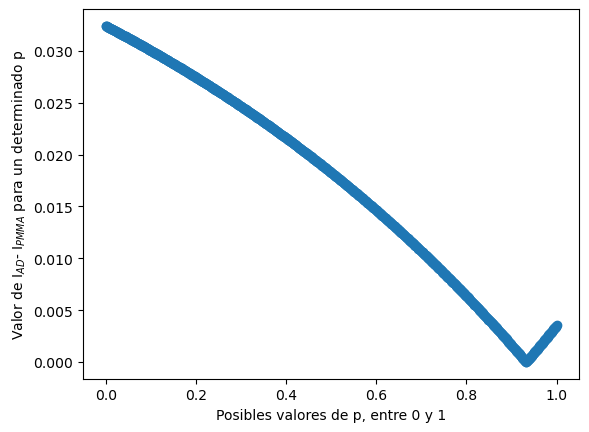

In [10]:
ps = np.linspace(0.0,1.0,1000)

residuals = [] # Aca se guaradaran las restas de I_PMMA con I_AD

d_esc= 3.161 # Esta es la altura de un escalon. Podemos cambiar este numero por la altura de los demas escalones

for p in ps:
    residuals.append(np.abs( I_AD(p) - I_PMMA(d_esc) ))

residuals = np.array(residuals)


index_where_residuals_is_min = np.where(residuals == np.amin(residuals)) # Posicion (indice) del valor para el cual la resta de las
#integrales es minima (muy cercana a cero)

print("La diferencia de integrales minima es: ", residuals[index_where_residuals_is_min], " y se alcanza para p=", ps[index_where_residuals_is_min])


plt.plot(ps, residuals, "o")
plt.xlabel("Posibles valores de p, entre 0 y 1")
plt.ylabel(r"Valor de I$_{AD}$- I$_{PMMA}$ para un determinado p")

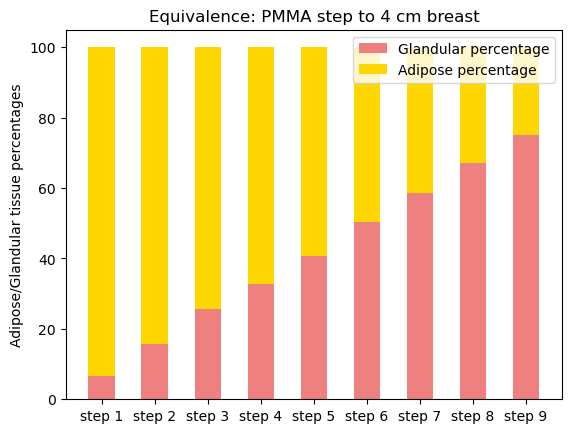

In [11]:
p_opt = np.genfromtxt("adipose_percentages.txt")

adipose_percentage = 100*p_opt
glandular_percentage = 100*(1 - p_opt)

labels = ['step 1', 'step 2', 'step 3', 'step 4', 'step 5', 'step 6', 'step 7', 'step 8', 'step 9']
#men_std = [2, 3, 4, 1, 2]
#women_std = [3, 5, 2, 3, 3]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

#ax.bar(labels, men_means, width, yerr=men_std, label='Men')
#ax.bar(labels, women_means, width, yerr=women_std, bottom=men_means,label='Women')
ax.bar(labels, glandular_percentage, width,label='Glandular percentage', color="#EF8080")
ax.bar(labels, adipose_percentage, width, bottom=glandular_percentage ,label='Adipose percentage', color="#FFD700")

ax.set_ylabel('Adipose/Glandular tissue percentages')
ax.set_title('Equivalence: PMMA step to 4 cm breast')
ax.legend()
#fig.savefig("porcentajes.svg")
plt.show()

In [12]:
p_opt = np.array([90,100-16,100-31,100-31,100-37,100-51,100-51,100-60,100-66])/100

for i,p in enumerate(p_opt):
    val1 = p*40
    val2 = ((p*40)/2.0) + ((1 - p)*40)/2.0
    val3 = (1-p)*40
    print("Lamina {}".format(i+1),val1,val3)

Lamina 1 36.0 3.999999999999999
Lamina 2 33.6 6.400000000000001
Lamina 3 27.599999999999998 12.400000000000002
Lamina 4 27.599999999999998 12.400000000000002
Lamina 5 25.2 14.8
Lamina 6 19.6 20.4
Lamina 7 19.6 20.4
Lamina 8 16.0 24.0
Lamina 9 13.600000000000001 26.4
